In [1]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!ls '/content/drive/MyDrive/Colab Notebooks/Sound'

In [4]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/Sound/train.zip' -d '/content/drive/MyDrive/Colab Notebooks/Proj4'

In [5]:
audio_paths = os.listdir('/content/drive/MyDrive/Colab Notebooks/Proj4/train')

In [6]:
audio_paths[:10]

['1251MN.wav',
 '1506MN.wav',
 '2107FS.wav',
 '0175FA.wav',
 '2056FA.wav',
 '2650FS.wav',
 '1615MA.wav',
 '2050MN.wav',
 '0566FN.wav',
 '1476MA.wav']

In [7]:
[len(i) for i in audio_paths][:10]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [8]:
len(audio_paths)

1994

<h3>Preprocessing Genders and Sentiments<h3>


In [9]:
id = []
gender = []
sentiment = []

for a in audio_paths:
 id.append(int(a[:4]))
 gender.append(1 if a[4]=='F' else 0)
 sentiment.append(a[5])

In [10]:
df = pd.DataFrame({
                   'id': id,
                   'gender': gender,
                   'sentiment': sentiment
})

In [11]:
df.sort_values(by = ['id'],inplace=True)
df.head()

,id,gender,sentiment
1308,0,0,A
1235,3,0,A
1200,4,0,N
497,5,1,S
1392,6,0,A


In [12]:
df['gender'].value_counts()

0    1155
1     839
Name: gender, dtype: int64

In [13]:
df['sentiment'].value_counts()

A    723
N    690
S    302
W    149
H    130
Name: sentiment, dtype: int64

Let's see the distribution of sentiments over each gender.

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
sns.set_palette(sns.color_palette("Reds"))

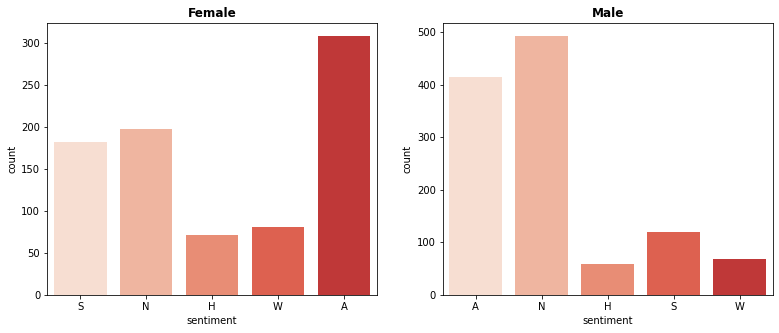

In [16]:
plt.rcParams["figure.figsize"]=13,5 
fig, ax = plt.subplots(1,2)

sns.countplot(data = df[df['gender']==1], x = 'sentiment',ax = ax[0]).set_title('Female',fontweight = 'bold')
sns.countplot(data = df[df['gender']==0], x = 'sentiment',ax = ax[1]).set_title('Male',fontweight = 'bold')


fig.show()

For example, we infere from the diagram that females are less angy or men are more neutral.

Now let's see it from other windows!

The distribution of genders over each five sentiments.

Before that, counts must be normalized in order not to propose distorted data.

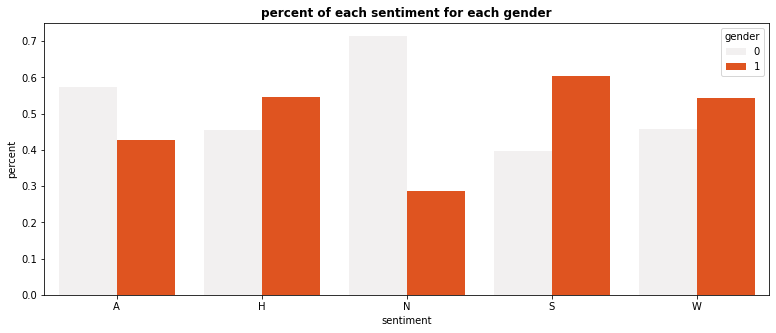

In [17]:
nrm = (df.groupby(['sentiment','gender']).size() / df.groupby(['sentiment']).size()).reset_index().rename({0:'percent'}, axis=1)
sns.barplot(x='sentiment', hue='gender', y='percent', data=nrm, color = 'orangered').set_title('percent of each sentiment for each gender',fontweight = 'bold')
plt.show()

In [18]:
from sklearn import preprocessing
from keras.utils import to_categorical

le = preprocessing.LabelEncoder()
sentiment = le.fit_transform(sentiment)

sentiment = to_categorical(sentiment).reshape(len(sentiment),-1)

In [19]:
sentiment[:5]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [20]:
# df['sentiment'][:5]

These plots indicates that we have more percent angry men than women or less percent sad men than women and other information which is obvious.

<h3>Load and Preprocessing Sounds<h3>

In [21]:
import librosa as lb

to see a sample:

In [22]:
dir = '/content/drive/MyDrive/Colab Notebooks/Proj4/train'
sample ,sr = lb.load(dir + '/' + audio_paths[10])

In [23]:
sr

22050

In [24]:
len(sample)

213279

In [25]:
sample[0]

-1.878384e-08

In [26]:
sample[1]

2.8734268e-08

In [27]:
import IPython.display as ipd
ipd.Audio(dir + '/' + audio_paths[10])

In [28]:
audio_paths[10]

'0448MS.wav'

As you heard, that's a sound of sad man.

Let's see what's the difference between waves of different sentiments

In [29]:
df.head(10)

,id,gender,sentiment
1308,0,0,A
1235,3,0,A
1200,4,0,N
497,5,1,S
1392,6,0,A
1746,8,1,N
660,11,0,N
1707,12,1,S
1311,13,1,H
1201,14,1,W


In [30]:
ind = [1455,1550,2,863,1484]
snt = ['Angry','Neutral','Sad','Happy','Surprised']
waves = [lb.load(dir + '/' + audio_paths[i]) for i in ind]

In [31]:
import librosa.display as lbd

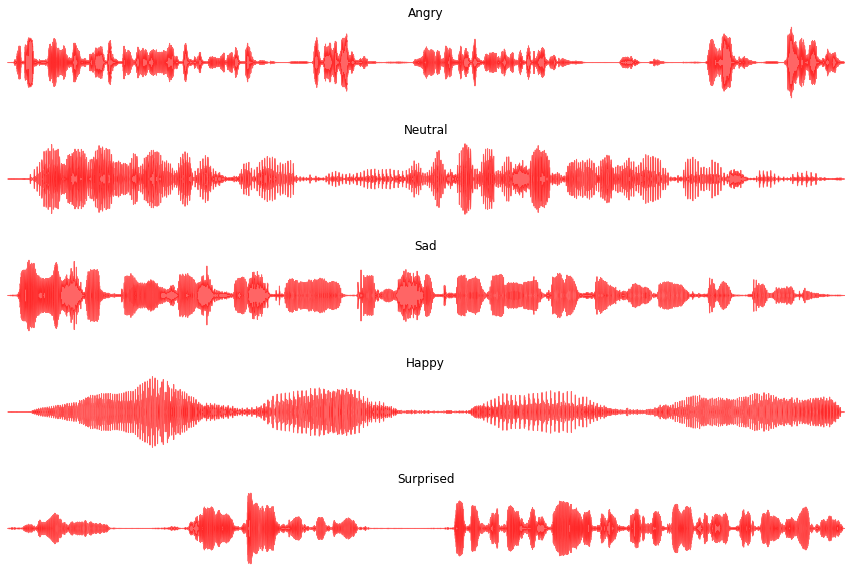

In [32]:
plt.rcParams["figure.figsize"]=15,10
plt.subplots_adjust(hspace = 0.5)
for i in range(5):
  ax = plt.subplot(5, 1, i + 1)
  plt.title(snt[i])
  lbd.waveplot(waves[i][0], color = 'r', alpha = 0.6)
  plt.axis("off")

<h4>Feature Extracting:<h4>

There are 2 features we intended to extract from audios and learn our NN using them respectively:

1- MFCC

2- MelSpectogram

See what MFCC do to the sound;

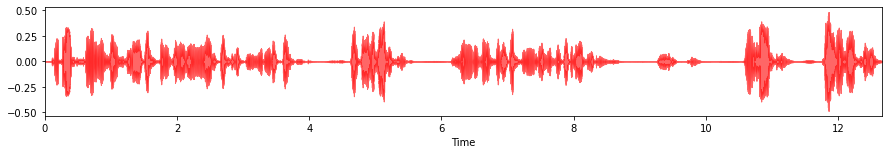

In [33]:
plt.rcParams["figure.figsize"]=15,2
lbd.waveplot(waves[0][0] ,color = 'red', alpha = 0.6)

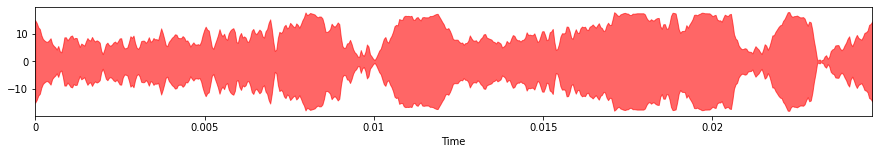

In [34]:
sample_mfcc = lb.feature.mfcc(y = waves[0][0], sr = waves[0][1],n_mfcc = 32)
lbd.waveplot(np.mean(sample_mfcc,axis = 0) ,color = 'red', alpha = 0.6)

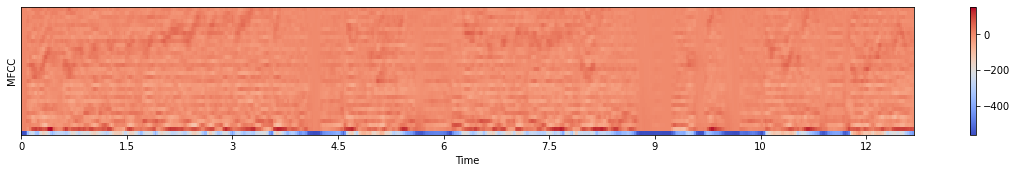

In [35]:
plt.figure(figsize=(20, 8))
plt.subplot(3,1,1)
lb.display.specshow(sample_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [36]:
import sklearn.model_selection as skm

In [37]:
audio_paths_women=[]
audio_paths_men=[]
sentiment_women=[]
sentiment_men=[]
for a in audio_paths:
  if a[4]=='F':
    audio_paths_women.append(a)
    sentiment_women.append(a[5])

  else:
    audio_paths_men.append(a)
    sentiment_men.append(a[5])

In [38]:
sentiment_women = le.fit_transform(sentiment_women)
sentiment_women = to_categorical(sentiment_women).reshape(len(sentiment_women),-1)

In [39]:
sentiment_men = le.fit_transform(sentiment_men)
sentiment_men = to_categorical(sentiment_men).reshape(len(sentiment_men),-1)

### mfcc:

### only women:

In [40]:
X_Wtrain, X_Wtest , y_Wtrain, y_Wtest = skm.train_test_split(audio_paths_women, sentiment_women, test_size = 0.3)

In [41]:
X_Wtrain = [lb.load(dir + '/' + i) for i in X_Wtrain]

In [42]:
X_Wtest = [lb.load(dir + '/' + i) for i in X_Wtest]

In [43]:
X_Wtrain_mfcc = [np.mean(lb.feature.mfcc(y=i[0],sr=i[1] ,n_mfcc=32),axis = 0 )for i in X_Wtrain] #32 16 64 are tested but not so much difference was observed

In [44]:
X_Wtest_mfcc = [  np.mean(lb.feature.mfcc(y=i[0],sr=i[1] ,n_mfcc=32),axis = 0 )for i in X_Wtest] #32 16 64

In [45]:
X_Wtrain_mfcc = [(x-min(x))/max(x) for x in X_Wtrain_mfcc]

In [46]:
X_Wtest_mfcc = [(x-min(x))/max(x) for x in X_Wtest_mfcc]

In [47]:
m1 = np.mean([len(X_Wtrain_mfcc[i]) for i in range(len(X_Wtrain_mfcc))])

In [48]:
fix_size = 180

for i in range(len(X_Wtrain_mfcc)):

    if len(X_Wtrain_mfcc[i]) > fix_size:
        X_Wtrain_mfcc[i] = X_Wtrain_mfcc[i][:fix_size]
        
    else:    
        while len(X_Wtrain_mfcc[i]) < fix_size:
           X_Wtrain_mfcc[i] = np.append(X_Wtrain_mfcc[i],0.0)

In [49]:
for i in range(len(X_Wtest_mfcc)):

    if len(X_Wtest_mfcc[i]) > fix_size:
        X_Wtest_mfcc[i] = X_Wtest_mfcc[i][:fix_size]
        
    else:    
        while len(X_Wtest_mfcc[i]) < fix_size:
           X_Wtest_mfcc[i] = np.append(X_Wtest_mfcc[i],0.0)

In [50]:
X_Wtrain_mfcc = np.array([[X_Wtrain_mfcc[i]] for i in range(len(X_Wtrain_mfcc))])
X_Wtest_mfcc = np.array([[X_Wtest_mfcc[i]] for i in range(len(X_Wtest_mfcc))])

### only men:

In [51]:
X_Mtrain, X_Mtest , y_Mtrain, y_Mtest = skm.train_test_split(audio_paths_men, sentiment_men, test_size = 0.7)

In [52]:
X_Mtrain = [lb.load(dir + '/' + i) for i in X_Mtrain]

In [53]:
X_Mtest = [lb.load(dir + '/' + i) for i in X_Mtest]

In [54]:
X_Mtrain_mfcc = [np.mean(lb.feature.mfcc(y=i[0],sr=i[1] ,n_mfcc=32),axis = 0 )for i in X_Mtrain] #32 16 64

In [55]:
X_Mtest_mfcc = [  np.mean(lb.feature.mfcc(y=i[0],sr=i[1] ,n_mfcc=32),axis = 0 )for i in X_Mtest] #32 16 64

In [56]:
X_Mtrain_mfcc = np.array([(x-min(x))/max(x) for x in X_Mtrain_mfcc])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [57]:
X_Mtest_mfcc = np.array([(x-min(x))/max(x) for x in X_Mtest_mfcc])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [58]:
for i in range(len(X_Mtrain_mfcc)):

    if len(X_Mtrain_mfcc[i]) > fix_size:
        X_Mtrain_mfcc[i] = X_Mtrain_mfcc[i][:fix_size]
        
    else:    
        while len(X_Mtrain_mfcc[i]) < fix_size:
           X_Mtrain_mfcc[i] = np.append(X_Mtrain_mfcc[i],0.0)

In [59]:

for i in range(len(X_Mtest_mfcc)):

    if len(X_Mtest_mfcc[i]) > fix_size:
        X_Mtest_mfcc[i] = X_Mtest_mfcc[i][:fix_size]
        
    else:    
        while len(X_Mtest_mfcc[i]) < fix_size:
           X_Mtest_mfcc[i] = np.append(X_Mtest_mfcc[i],0.0)

In [60]:
X_Mtrain_mfcc = np.array([[X_Mtrain_mfcc[i]] for i in range(len(X_Mtrain_mfcc))])
X_Mtest_mfcc = np.array([[X_Mtest_mfcc[i]] for i in range(len(X_Mtest_mfcc))])

### all:

In [61]:
X_train, X_test , y_train, y_test = skm.train_test_split(audio_paths, sentiment, test_size = 0.3)

In [62]:
X_train = [lb.load(dir + '/' + i) for i in X_train]

In [63]:
X_test = [lb.load(dir + '/' + i) for i in X_test]

In [64]:
X_train_mfcc = [np.mean(lb.feature.mfcc(y=i[0], sr=i[1], n_mfcc=32),axis = 0 )for i in X_train] #32 16 64

In [65]:
X_test_mfcc = [  np.mean(lb.feature.mfcc(y=i[0], sr=i[1], n_mfcc=32),axis = 0 )for i in X_test] #32 16 64

In [66]:
len(X_train_mfcc)

1395

In [67]:
len(X_train_mfcc[0])

56

Normalization:

In [68]:
X_train_mfcc = np.array([(x-min(x))/max(x-min(x)) for x in X_train_mfcc])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [69]:
X_test_mfcc = np.array([(x-min(x))/max(x-min(x)) for x in X_test_mfcc])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [70]:
for i in range(len(X_train_mfcc)):

    if len(X_train_mfcc[i]) > fix_size:
        X_train_mfcc[i] = X_train_mfcc[i][:fix_size]
        
    else:    
        while len(X_train_mfcc[i]) < fix_size:
           X_train_mfcc[i] = np.append(X_train_mfcc[i],0.0)

In [71]:
for i in range(len(X_test_mfcc)):

    if len(X_test_mfcc[i]) > fix_size:
        X_test_mfcc[i] = X_test_mfcc[i][:fix_size]
        
    else:    
        while len(X_test_mfcc[i]) < fix_size:
           X_test_mfcc[i] = np.append(X_test_mfcc[i],0.0)

In [72]:
X_train_mfcc = np.array([[X_train_mfcc[i]] for i in range(len(X_train_mfcc))])
X_test_mfcc = np.array([[X_test_mfcc[i]] for i in range(len(X_test_mfcc))])

### melspectogram

In [73]:
X_train_melspectogram = [np.mean(lb.feature.melspectrogram(y=i[0], sr=i[1], n_mels=64, n_fft=1280, fmin=20, fmax=sr//2),axis = 0)for i in X_train] #32 16 64

In [74]:
X_test_melspectogram = [np.mean(lb.feature.melspectrogram(y=i[0], sr=i[1], n_mels=64, n_fft=1280, fmin=20, fmax=sr//2),axis = 0)for i in X_test] #32 16 64

In [75]:
len(X_train_melspectogram)

1395

In [76]:
#Normalization
X_train_melspectogram = np.array([(x-min(x))/max(x) for x in X_train_melspectogram])
X_test_melspectogram = np.array([(x-min(x))/max(x) for x in X_test_melspectogram])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:

for i in range(len(X_train_melspectogram)):

    if len(X_train_melspectogram[i]) > fix_size:
        X_train_melspectogram[i] = X_train_melspectogram[i][:fix_size]
        
    else:    
        while len(X_train_melspectogram[i]) < fix_size:
           X_train_melspectogram[i] = np.append(X_train_melspectogram[i],0.0)


for i in range(len(X_test_melspectogram)):

    if len(X_test_melspectogram[i]) > fix_size:
        X_test_melspectogram[i] = X_test_melspectogram[i][:fix_size]
        
    else:    
        while len(X_test_melspectogram[i]) < fix_size:
           X_test_melspectogram[i] = np.append(X_test_melspectogram[i],0.0)

X_train_melspectogram = np.array([[X_train_melspectogram[i]] for i in range(len(X_train_melspectogram))])
X_test_melspectogram = np.array([[X_test_melspectogram[i]] for i in range(len(X_test_melspectogram))])


### <h2>Create Model<h2>

In [78]:
from tensorflow.keras.layers import Dense , Dropout ,Input , LSTM , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

In [79]:
input_layer = Input(shape=(1,180), name ="input")
lstm_layer = LSTM(120, return_sequences=False)(input_layer)

X = Dense(64 ,activation='relu' , name="layer1")(lstm_layer)
X = BatchNormalization(axis = 1)(X)
X = Dense(32 ,activation='relu' , name="layer9876541")(X)
X = Dropout(0.1)(X)
X = BatchNormalization(axis = 1)(X)
X = Dense(16 ,activation='tanh' , name="lay")(X)
X = BatchNormalization(axis = 1)(X)
X = Dropout(0.1)(X)
X = Dense(9 ,activation='relu' , name="layer298")(X)
# X = Dropout(0.1)(X)
X = BatchNormalization(axis = 1)(X)
output_layer = Dense(5 ,activation='softmax' , name="output")(X)

model = Model(inputs=input_layer, outputs=output_layer , name = "model")

In [80]:
sgd = SGD(lr=0.1, momentum=0.8)
#ADAM
#RMSPROP
#ADADELTA 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

##Evaluation:

In [81]:
from sklearn.metrics import confusion_matrix
##ARGMAX
def draw_confusion_matrix(y_true, y_pred):
  categories = ['Anger','Neutral','Sad','Surprised','Happy']
  data = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(data)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (8,8))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Reds",square=True,fmt="d", annot=True,annot_kws={"size": 12},xticklabels=categories, yticklabels=categories)
  plt.show()

mfcc:

### only men:

In [82]:
es1 = EarlyStopping(monitor='accuracy', verbose=1,mode = 'max', patience=20)
es2 = EarlyStopping(monitor='loss', verbose=1, patience=20,mode = 'min' ) #when validation loss starts to increase means we start overfitting so it stops after 10 epochs
eses = [es1,es2]

history = model.fit(X_Mtrain_mfcc, y_Mtrain, epochs=1000,batch_size = 20,callbacks = eses,verbose = 2,validation_data = (X_Mtest_mfcc,y_Mtest),validation_freq=5)

Epoch 1/1000
18/18 - 3s - loss: 1.8932 - accuracy: 0.2110
Epoch 2/1000
18/18 - 0s - loss: 1.6152 - accuracy: 0.3179
Epoch 3/1000
18/18 - 0s - loss: 1.5698 - accuracy: 0.3353
Epoch 4/1000
18/18 - 0s - loss: 1.5063 - accuracy: 0.3410
Epoch 5/1000
18/18 - 1s - loss: 1.4459 - accuracy: 0.4566 - val_loss: 1.5607 - val_accuracy: 0.3869
Epoch 6/1000
18/18 - 0s - loss: 1.4109 - accuracy: 0.4306
Epoch 7/1000
18/18 - 0s - loss: 1.3852 - accuracy: 0.4595
Epoch 8/1000
18/18 - 0s - loss: 1.4066 - accuracy: 0.4624
Epoch 9/1000
18/18 - 0s - loss: 1.3328 - accuracy: 0.4913
Epoch 10/1000
18/18 - 0s - loss: 1.3420 - accuracy: 0.5087 - val_loss: 1.6330 - val_accuracy: 0.2188
Epoch 11/1000
18/18 - 0s - loss: 1.3371 - accuracy: 0.5087
Epoch 12/1000
18/18 - 0s - loss: 1.2854 - accuracy: 0.5491
Epoch 13/1000
18/18 - 0s - loss: 1.2530 - accuracy: 0.5462
Epoch 14/1000
18/18 - 0s - loss: 1.2693 - accuracy: 0.5318
Epoch 15/1000
18/18 - 0s - loss: 1.1947 - accuracy: 0.5809 - val_loss: 1.3878 - val_accuracy: 0.443

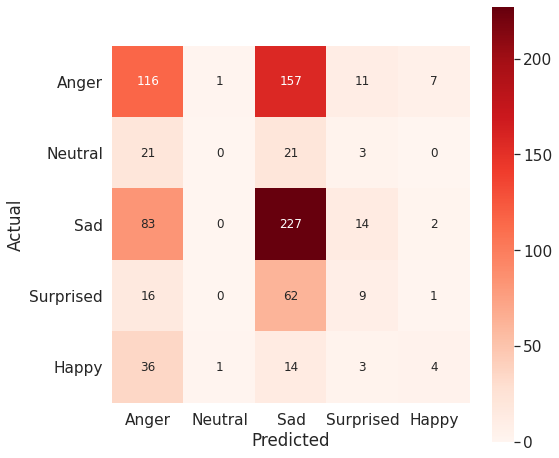

In [83]:
y_true = np.argmax(y_Mtest, axis = -1)
y_predict = np.argmax(model.predict(X_Mtest_mfcc), axis = -1)
draw_confusion_matrix(y_true, y_predict)

### only women:

In [84]:
history = model.fit(X_Wtrain_mfcc, y_Wtrain, epochs=1000,batch_size = 20,callbacks = eses,verbose = 2,validation_data = (X_Wtest_mfcc,y_Wtest),validation_freq=5)

Epoch 1/1000
30/30 - 0s - loss: 1.9931 - accuracy: 0.3152
Epoch 2/1000
30/30 - 0s - loss: 1.6498 - accuracy: 0.3646
Epoch 3/1000
30/30 - 0s - loss: 1.5001 - accuracy: 0.3901
Epoch 4/1000
30/30 - 0s - loss: 1.4579 - accuracy: 0.4037
Epoch 5/1000
30/30 - 0s - loss: 1.4145 - accuracy: 0.3969 - val_loss: 1.5724 - val_accuracy: 0.3611
Epoch 6/1000
30/30 - 0s - loss: 1.3849 - accuracy: 0.4225
Epoch 7/1000
30/30 - 0s - loss: 1.3341 - accuracy: 0.4583
Epoch 8/1000
30/30 - 0s - loss: 1.3192 - accuracy: 0.4600
Epoch 9/1000
30/30 - 0s - loss: 1.3133 - accuracy: 0.4719
Epoch 10/1000
30/30 - 0s - loss: 1.2998 - accuracy: 0.4719 - val_loss: 1.5131 - val_accuracy: 0.3214
Epoch 11/1000
30/30 - 0s - loss: 1.2674 - accuracy: 0.4719
Epoch 12/1000
30/30 - 0s - loss: 1.2663 - accuracy: 0.4736
Epoch 13/1000
30/30 - 0s - loss: 1.2562 - accuracy: 0.4855
Epoch 14/1000
30/30 - 0s - loss: 1.2298 - accuracy: 0.5026
Epoch 15/1000
30/30 - 0s - loss: 1.2286 - accuracy: 0.5162 - val_loss: 1.5788 - val_accuracy: 0.341

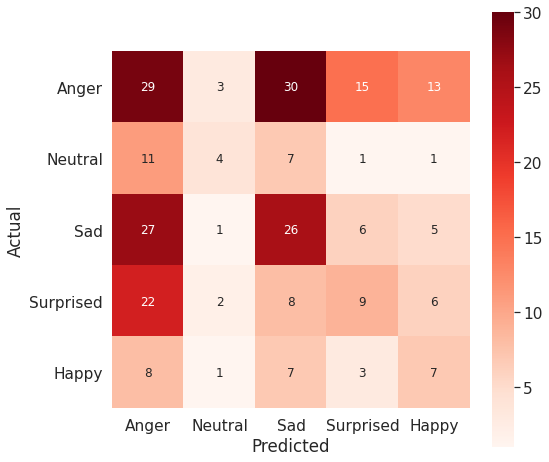

In [85]:
y_true = np.argmax(y_Wtest, axis = -1)
y_predict = np.argmax(model.predict(X_Wtest_mfcc), axis = -1)
draw_confusion_matrix(y_true, y_predict)

as you can see there isn't much difference between men and women.

### all:

In [86]:
history = model.fit(X_train_mfcc, y_train, epochs=1000,batch_size = 20,callbacks = eses,verbose = 2,validation_data = (X_test_mfcc,y_test),validation_freq=5)

Epoch 1/1000
70/70 - 0s - loss: 1.8754 - accuracy: 0.3871
Epoch 2/1000
70/70 - 0s - loss: 1.4088 - accuracy: 0.4344
Epoch 3/1000
70/70 - 0s - loss: 1.3566 - accuracy: 0.4351
Epoch 4/1000
70/70 - 0s - loss: 1.3287 - accuracy: 0.4409
Epoch 5/1000
70/70 - 0s - loss: 1.3029 - accuracy: 0.4523 - val_loss: 1.4259 - val_accuracy: 0.4124
Epoch 6/1000
70/70 - 0s - loss: 1.2950 - accuracy: 0.4609
Epoch 7/1000
70/70 - 0s - loss: 1.3025 - accuracy: 0.4588
Epoch 8/1000
70/70 - 0s - loss: 1.2886 - accuracy: 0.4717
Epoch 9/1000
70/70 - 0s - loss: 1.2630 - accuracy: 0.4846
Epoch 10/1000
70/70 - 0s - loss: 1.2550 - accuracy: 0.4817 - val_loss: 1.2830 - val_accuracy: 0.4775
Epoch 11/1000
70/70 - 0s - loss: 1.2403 - accuracy: 0.4982
Epoch 12/1000
70/70 - 0s - loss: 1.2477 - accuracy: 0.4939
Epoch 13/1000
70/70 - 0s - loss: 1.2597 - accuracy: 0.4810
Epoch 14/1000
70/70 - 0s - loss: 1.2278 - accuracy: 0.4896
Epoch 15/1000
70/70 - 0s - loss: 1.2341 - accuracy: 0.4910 - val_loss: 1.2961 - val_accuracy: 0.492

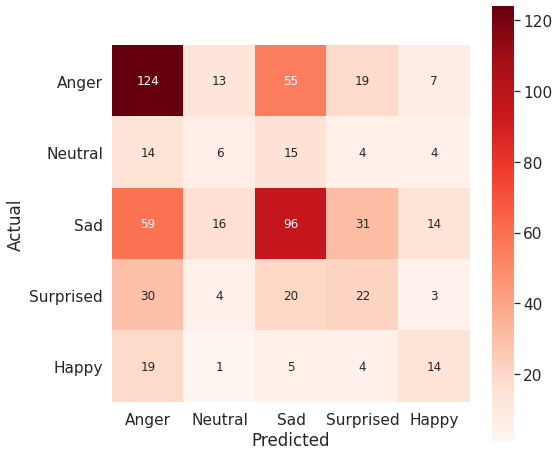

In [87]:
y_true = np.argmax(y_test, axis = -1)
y_predict = np.argmax(model.predict(X_test_mfcc), axis = -1)
draw_confusion_matrix(y_true, y_predict)

### melspectogram on all:

In [88]:
history = model.fit(X_train_melspectogram, y_train, epochs=1000,batch_size = 20,callbacks = eses,verbose = 2,validation_data = (X_test_melspectogram,y_test),validation_freq=5)

Epoch 1/1000
70/70 - 0s - loss: 2.1170 - accuracy: 0.3670
Epoch 2/1000
70/70 - 0s - loss: 1.4025 - accuracy: 0.4366
Epoch 3/1000
70/70 - 0s - loss: 1.3180 - accuracy: 0.4595
Epoch 4/1000
70/70 - 0s - loss: 1.2447 - accuracy: 0.4832
Epoch 5/1000
70/70 - 0s - loss: 1.1793 - accuracy: 0.5004 - val_loss: 1.4256 - val_accuracy: 0.4491
Epoch 6/1000
70/70 - 0s - loss: 1.1678 - accuracy: 0.5140
Epoch 7/1000
70/70 - 0s - loss: 1.1250 - accuracy: 0.5348
Epoch 8/1000
70/70 - 0s - loss: 1.1037 - accuracy: 0.5362
Epoch 9/1000
70/70 - 0s - loss: 1.0723 - accuracy: 0.5713
Epoch 10/1000
70/70 - 0s - loss: 1.0710 - accuracy: 0.5599 - val_loss: 1.4403 - val_accuracy: 0.4474
Epoch 11/1000
70/70 - 0s - loss: 1.0331 - accuracy: 0.5706
Epoch 12/1000
70/70 - 0s - loss: 1.0019 - accuracy: 0.5957
Epoch 13/1000
70/70 - 0s - loss: 0.9549 - accuracy: 0.6151
Epoch 14/1000
70/70 - 0s - loss: 0.9441 - accuracy: 0.6287
Epoch 15/1000
70/70 - 0s - loss: 0.9116 - accuracy: 0.6165 - val_loss: 1.5062 - val_accuracy: 0.437

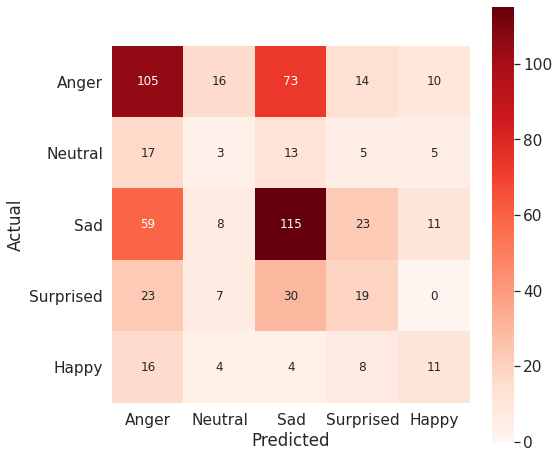

In [89]:
y_true = np.argmax(y_test, axis = -1)
y_predict = np.argmax(model.predict(X_test_melspectogram), axis = -1)
draw_confusion_matrix(y_true, y_predict)

2 and 0 are more mislabeled and also labeled correctly than others!

In [90]:
import joblib
joblib.dump(value=model.weights, filename=f"weights_pr4-2.pkl")

['weights_pr4-2.pkl']